<h1>Google Ranking Algorithm</h1>

In [53]:
import numpy as np
import urllib.request
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [21]:
#dictionary of urls
url_targets = {}
url_pointers = {}
#damping factor
d = 0.85
#creeper iterations
creeper_iterations=2
#base url
base_url = "https://en.wikipedia.org"
#initial url
initial_url = "/wiki/Black_Hole_Initiative"

<h1>Crawler</h1>

In [22]:
def crawler(initial_url, creeper_iterations):
    htmls = os.listdir('wiki')
    #list of websites a website ponts to 
    url_targets = {}
    open_urls = [initial_url]
    for n in range(creeper_iterations):
        print(n)
        new_urls = set()
        for url in tqdm(open_urls):
            url_targets[url] = set()
            try:
                file_name = '_'.join(url.split('/')[2:])+'.html'
                if file_name.replace('*','<star>') in htmls:
                    file = open('wiki/'+file_name,encoding="utf-8").read()
                else:    
                    file = urllib.request.urlopen(base_url+url).read().decode("utf-8")
                    html = open('wiki/'+file_name.replace('*',''),"w+",encoding="utf-8")
                    html.write(file)
                    html.close()
                file = file.replace(" ","")
                url_list =file.split('href="')
                for k in range(len(url_list)):
                    url_list[k] = url_list[k].split('"')[0]
                for found_url in url_list:
                    if not found_url in url_targets.keys() and "/wiki/" == found_url[:6] \
                    and not "#" in found_url and not ":" in found_url:
                        new_urls.add(found_url)
                    if not found_url in url_targets[url]:
                        url_targets[url].add(found_url)
            except Exception as e: 
                print(str(e))
            open_urls = new_urls
    for key in url_targets:
        new_targets = set()
        for target in url_targets[key]:
            if target in url_targets.keys():
                new_targets.add(target)
        url_targets[key] = new_targets
    return url_targets


In [23]:
url_targets = crawler(initial_url, creeper_iterations)

0



1


<h1>Relaxation Method</h1>

We assume page $A$ has pages $T_1 ... T_n$ which point to it (i.e., are citations). The parameter $d$ is a damping factor which can be set between 0 and 1. We usually set $d$ to 0.85. There are more details about $d$ in the next section. Also $C(A)$ is defined as the number of links going out of page $A$. The PageRank of a page $A$ is given as follows:<br><br>
$$PR(A) = (1-d) + d (PR(T_1)/C(T_1) + ... + PR(T_n)/C(T_n))$$<br>
Note that the PageRanks form a probability distribution over web pages, so the sum of all web pages' PageRanks will be one.

In [26]:
def relaxation(times, url_targets):
    start_time = time.time()
    page_rank = {}
    for key in url_targets:
        page_rank[key] = 1/len(url_targets[key])
    for n in range(times):
        new_rank = {}
        for key in page_rank:
            new_rank[key] = 1-d
            for sum_key in page_rank:
                if key in url_targets[sum_key]:
                    new_rank[key] += d*page_rank[sum_key]/len(url_targets[sum_key])
        page_rank = new_rank.copy()
    page_rank = {url: rank for url, rank in sorted(page_rank.items(), key=lambda item: item[1], reverse=True)}
    return page_rank, time.time() - start_time

In [16]:
page_rank, time = relaxation(1, url_targets)
print('time to run', time)


time to run:  0.030921220779418945


In [7]:
[(key,page_rank[key]) for key in page_rank.keys()][:10]

[('/wiki/Main_Page', 8.828104827527515),
 ('/wiki/Black_hole', 1.15439880271944),
 ('/wiki/Dark_matter', 1.138515241404342),
 ('/wiki/Universe', 1.0739052881659963),
 ('/wiki/Supernova', 1.06405236425116),
 ('/wiki/General_relativity', 1.0621183265611853),
 ('/wiki/Galaxy', 0.9913803371022254),
 ('/wiki/Dark_energy', 0.9449846788778061),
 ('/wiki/White_dwarf', 0.933710808031581),
 ('/wiki/Neutron_star', 0.9286638536722459)]

1
2
3
4
5
6
7
8
9
10


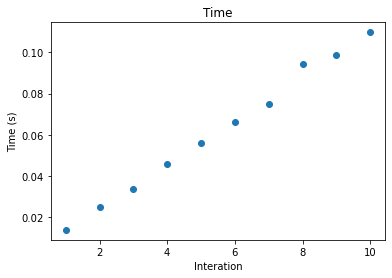

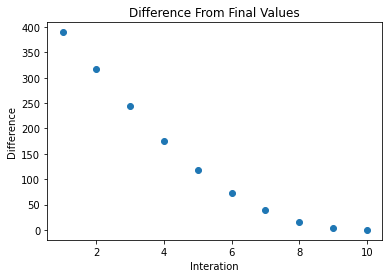

In [40]:
trials = 11
x = list(range(1,trials))
times = []
page_ranks = []
diffs = []
for n in range(1,trials):
    print(n)
    page_rank, this_time = relaxation(n, url_targets)
    times.append(this_time)
    page_ranks.append(page_rank)
for page_rank in page_ranks:
    diff = 0
    for key in page_rank:
        diff += (page_rank[key]-page_ranks[-1][key])**2
    diffs.append(diff)
plt.scatter(x,times)
plt.title('Time')
plt.xlabel('Interation')
plt.ylabel('Time (s)')
plt.show()
plt.scatter(x,diffs)
plt.title('Difference From Final Values')
plt.xlabel('Interation')
plt.ylabel('Difference')
plt.show()

<h1>Linear Algebra</h1>

$$PR(A) = (1-d) + d (PR(T_1)/C(T_1) + ... + PR(T_n)/C(T_n))$$<br>
$$PR(A) - d (PR(T_1)/C(T_1) + ... + PR(T_n)/C(T_n)) = 1-d$$<br>
$$\begin{bmatrix}1 & -d/C_1(T_2) & ... \\ 
-d/C_2(T_1) & 1 & ... \\ \vdots & \vdots & \ddots \end{bmatrix} \begin{bmatrix}PR(A_1) \\ PR(A_2) \\ \vdots \end{bmatrix} = 
\begin{bmatrix}1-d \\ 1-d \\ \vdots \end{bmatrix}$$<br>
$$\begin{bmatrix}PR(A_1) \\ PR(A_2) \\ \vdots \end{bmatrix} = 
\begin{bmatrix}1-d \\ 1-d \\ \vdots \end{bmatrix}\begin{bmatrix}1 & -d/C_1(T_2) & ... \\ 
-d/C_2(T_1) & 1 & ... \\ \vdots & \vdots & \ddots \end{bmatrix}^{-1}$$

In [73]:
def matrix_rank(url_targets):
    start_time = time.time()
    keys = list(url_targets.keys())
    b = np.zeros(len(keys))+1-d
    A = np.identity(len(keys))
    for row in range(len(keys)):
        for column in range(len(keys)):
            if row != column and keys[column] in url_targets[keys[row]]:
                A[row,column] = -d/len(url_targets[keys[row]])
    PR = np.matmul(b.T,np.linalg.inv(A))
    return {keys[n]:PR[n] for n in range(len(PR))}, time.time() - start_time

In [74]:
page_rank, this_time = matrix_rank(url_targets)
print('time to run', this_time)

page_rank = {url: rank for url, rank in sorted(page_rank.items(), key=lambda item: item[1], reverse=True)}
[(key,page_rank[key]) for key in page_rank.keys()][:10]

time to run 0.01495981216430664


[('/wiki/Main_Page', 4.5236154060440725),
 ('/wiki/Black_hole', 1.8426238105143034),
 ('/wiki/Supernova', 1.7004531845537845),
 ('/wiki/Dark_matter', 1.6849156100396894),
 ('/wiki/General_relativity', 1.6588876835802195),
 ('/wiki/Universe', 1.564350720769985),
 ('/wiki/Galaxy', 1.501255631936278),
 ('/wiki/Neutron_star', 1.4945359986560995),
 ('/wiki/White_dwarf', 1.486001523902547),
 ('/wiki/Dark_energy', 1.3737415360304055)]

In [85]:
test_targets = crawler(initial_url, 3)

0



1



2


Text(0, 0.5, 'ln(time (s))')

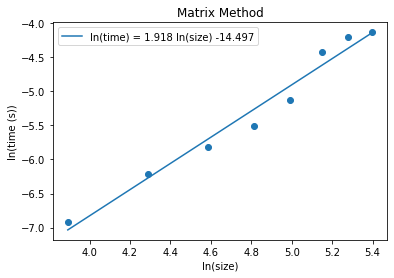

In [107]:
pieces = 10
x = []
times = []
for n in range(2,pieces):
    size = len(url_targets.keys())*n//pieces
    x.append(size)
    test_keys = list(url_targets.keys())[:size]
    test_url_targets = {url: url_targets[url] & set(test_keys) for url in test_keys}
    page_rank, this_time = matrix_rank(test_url_targets)
    times.append(this_time)
x = np.array(x)
times = np.array(times)
m, b = np.polyfit(np.log(x),np.log(times), 1)
plt.plot(np.log(x),m*np.log(x)+b,label='ln(time) = '+str(round(m,3))+' ln(size) '+str(round(b,3)))
plt.scatter(np.log(x),np.log(times))
plt.legend()
plt.title('Matrix Method')
plt.xlabel('ln(size)')
plt.ylabel('ln(time (s))')

<h1>Random Walk</h1>

In [127]:
def random_rank(steps, walkers,url_targets):
    start_time = time.time()
    urls = list(url_targets.keys())
    #initial positions
    for walker in range(walkers):
        positions = np.random.choice(urls,walkers)
    for step in range(steps):
        for walker in range(walkers):
            positions[walker] = np.random.choice(list(url_targets[positions[walker]]))
    return {url: (1-d) + d*np.sum(positions == url)/walkers for url in urls}, time.time() - start_time

In [128]:
page_rank, this_time = random_rank(5,10**4,url_targets)
print('time to run', this_time)

page_rank = {url: rank for url, rank in sorted(page_rank.items(), key=lambda item: item[1], reverse=True)}
[(key,page_rank[key]) for key in page_rank.keys()][:10]

time to run 13.295462131500244


[('/wiki/Main_Page', 0.27172),
 ('/wiki/Supernova', 0.160115),
 ('/wiki/Black_hole', 0.15850000000000003),
 ('/wiki/General_relativity', 0.15739500000000003),
 ('/wiki/Dark_matter', 0.15731000000000003),
 ('/wiki/Neutron_star', 0.15654500000000002),
 ('/wiki/Universe', 0.15654500000000002),
 ('/wiki/Dark_energy', 0.15629),
 ('/wiki/Galaxy', 0.15629),
 ('/wiki/Exotic_matter', 0.156205)]

1000
2000
3000
4000
5000
6000
7000
8000
9000


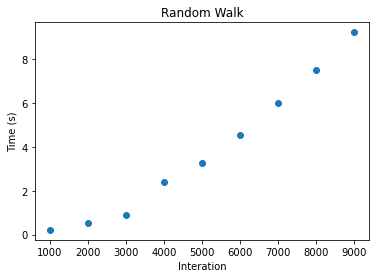

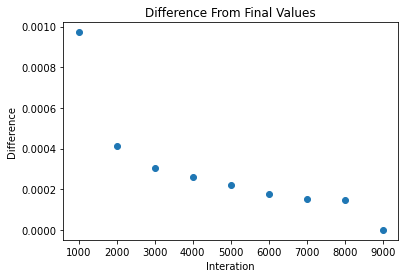

In [122]:
exponent = 4
number_of_walkers = np.arange(10**(exponent-1),10**exponent,10**(exponent-1))
times = []
page_ranks = []
diffs = []
for walkers in number_of_walkers:
    print(walkers)
    page_rank, this_time = random_rank(5, walkers,url_targets)
    times.append(this_time)
    page_ranks.append(page_rank)
for page_rank in page_ranks:
    diff = 0
    for key in page_rank:
        diff += (page_rank[key]-page_ranks[-1][key])**2
    diffs.append(diff)
plt.scatter(number_of_walkers,times)
plt.title('Random Walk')
plt.xlabel('Walkers')
plt.ylabel('Time (s)')
plt.show()
plt.scatter(number_of_walkers,diffs)
plt.title('Difference From Final Values')
plt.xlabel('Walkers')
plt.ylabel('Difference')
plt.show()

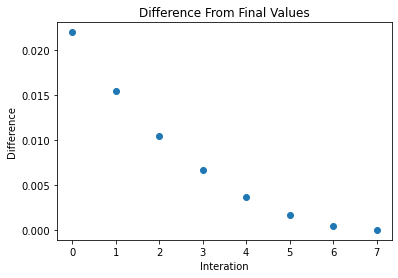

In [126]:
page_ranks=[]
diffs=[]
x=[]
steps=8
walkers = 10**4
urls = list(url_targets.keys())
#initial positions
for walker in range(walkers):
    positions = np.random.choice(urls,walkers)
for step in range(steps):
    for walker in range(walkers):
        positions[walker] = np.random.choice(list(url_targets[positions[walker]]))
    page_ranks.append({url: (1-d) + d*np.sum(positions == url)/walkers for url in urls})
    x.append(step)
for page_rank in page_ranks:
    diff = 0
    for key in page_rank:
        diff += (page_rank[key]-page_ranks[-1][key])**2
    diffs.append(diff)
plt.scatter(x,diffs)
plt.title('Difference From Final Values Random Walk')
plt.xlabel('Interation')
plt.ylabel('Difference')
plt.show()

In [ ]:
pieces = 10
x = []
times = []
for n in range(3,pieces):
    size = len(url_targets.keys())*n//pieces
    x.append(size)
    test_keys = list(url_targets.keys())[:size]
    test_url_targets = {url: url_targets[url] & set(test_keys) for url in test_keys}
    page_rank, this_time = random_rank(5,10**4,test_url_targets)
    times.append(this_time)
x = np.array(x)
times = np.array(times)
m, b = np.polyfit(np.log(x),np.log(times), 1)
plt.plot(np.log(x),m*np.log(x)+b,label='ln(time) = '+str(round(m,3))+' ln(size) '+str(round(b,3)))
plt.scatter(np.log(x),np.log(times))
plt.legend()
plt.title('Random Walk Method')
plt.xlabel('ln(size)')
plt.ylabel('ln(time (s))')